In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


carico il db delle immagini di input (1446 immagini RGB, con dimensione 195 x 260)

In [0]:
import numpy as np
PATH_BASE = '/content/drive/My Drive/Appunti delle lezioni/2Anno2Semestre/Digital Image Processing/surface_normal_estimation/'

In [0]:
immagini_db = np.load(PATH_BASE + 'input_imgs_dataset.npy')

In [0]:
print(immagini_db.shape)
N = immagini_db.shape[0]

(1446, 195, 260, 3)


# Preprocessing

importo i dati di output sulle normali.
Per ogni pixel la normale è un vettore di 3 componenti (x,y,z), nel range [-1,1].

In [0]:
normali = np.load(PATH_BASE + '/normals_orig.npy')

In [0]:
print(normali.shape)
#print(normali[0])
# visualizzo le normali come immagine RGB
normali_vis = (255/2.0 * (normali + 1)).astype(int)
#print(normali_vis[0])

(1446, 195, 260, 3)


visualizzo alcune coppie di immagine di input e mappa delle normali (trasformata in immagine RGB)

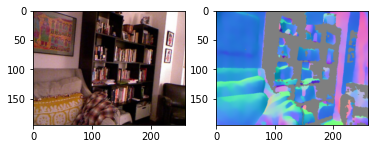

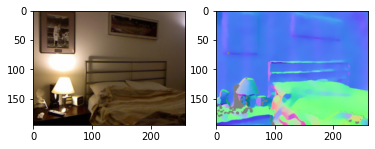

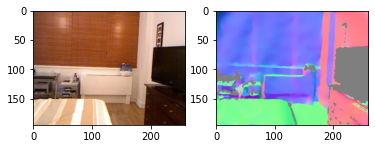

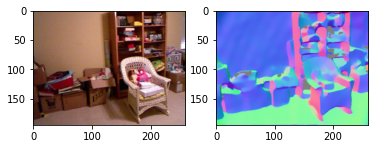

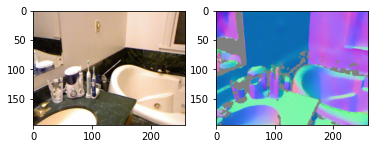

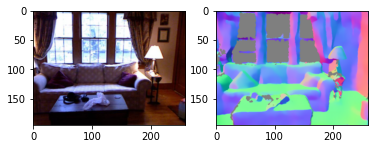

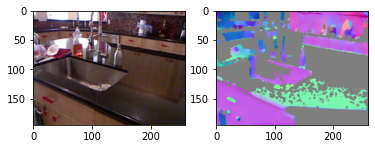

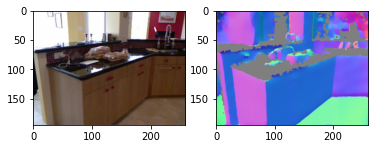

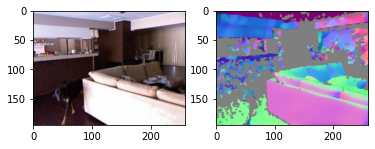

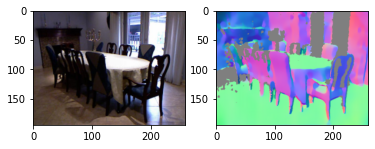

In [0]:
# visualizzo alcune coppie input/output: (immagine di input/normali di output)
%matplotlib inline
import matplotlib.pyplot as plt

rnd = np.sort(np.random.randint(N, size=10))
for i in rnd:
  plt.figure('input img/output normals')
  plt.subplot(121)
  plt.imshow(immagini_db[i])

  plt.subplot(122)
  plt.imshow(normali_vis[i])
  plt.show()

funzione per effettuare il clustering delle normali in 40 centroidi di riferimento.

Trasformazione del problema iniziale in problema di classificazione.

Queste label sono quelle da dare alla rete per il training.

In [0]:
import scipy.cluster.vq
def get_normals_k_means(k, normals):
    print('clustering...')
    print(normals.shape)
    # reshaping flatting elements row-wise merging channels in 3 length vectors
    points = normals.reshape(-1, 3)
    print(points.shape)
    codebook, labels = scipy.cluster.vq.kmeans2(points, k, iter=10, minit='points')
    reshaped_labels = labels.reshape(normals.shape[0:3])
    print('done')
    return codebook, reshaped_labels

In [0]:
# converto le normali in una label delle 40 possibili

# clustering in 40 centroidi
k = 40
codebook, reshaped_labels = get_normals_k_means(k, normali)


clustering...
(1446, 195, 260, 3)
(73312200, 3)


/usr/local/lib/python3.6/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


done


In [0]:
# salvo
np.save(PATH_BASE + "normals_centroid_labels.npy", reshaped_labels)
np.save(PATH_BASE + "codebook_labels_3d_components.npy", codebook)

In [0]:
reshaped_labels = np.load(PATH_BASE + "normals_centroid_labels.npy")
codebook = np.load(PATH_BASE + "codebook_labels_3d_components.npy")

In [0]:
print(codebook.shape)
print(reshaped_labels.shape)

(40, 3)
(1446, 195, 260)


Visualizzo i 40 centroidi in 3d

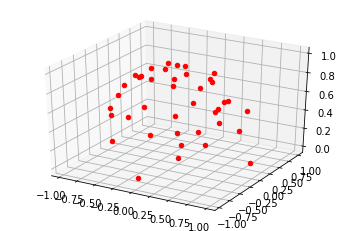

In [0]:
def plot_means_and_clusters(normals, codebook):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #for p in normals.reshape(-1, 3):
    #    ax.scatter(p[0], p[1], p[2], c='c')
    for m in codebook:
        ax.scatter(m[0], m[1], m[2], c='r')
    plt.show()
plot_means_and_clusters(normali, codebook)

In [0]:
# carico il codebook
codebook = np.load(PATH_BASE + "codebook_labels_3d_components.npy")

Metodo per ricostruire una normale 3D a partire dall'output della rete (vettore di probabilità per le 40 classi).

#Postprocessing e Valutazione

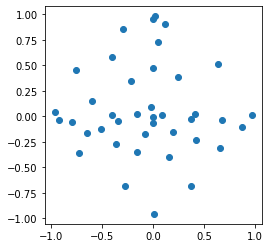

(68, 3)


In [0]:
import scipy as sp
import matplotlib.pyplot as plt
from scipy import spatial

# Triangolazione di delaunay a partire dai 40 centroidi di riferimento.
def get_delaunay_triangulation(codebook):
  tri = sp.spatial.Delaunay(codebook[:,0:2]) # perform triangulation over x and y coordinates (z is function of (x,y))
  #print(tri.simplices)
  plt.figure()
  plt.axes().set_aspect('equal')
  #plt.triplot(codebook[:,0], codebook[:,1], tri.simplices.copy())
  plt.plot(codebook[:,0], codebook[:,1], 'o')
  plt.show()
  return tri.simplices

# ottengo la triangolazione a partire dalle proiezioni 2D delle 40 normali di riferimento (centroidi)
triangoli = get_delaunay_triangulation(codebook)
print(triangoli.shape)


In [0]:

# Metodo che permette di ottenere la normale 3d per ogni pixel a partire dalla predizione della rete.
# INPUT
# netPrediction: shape = (H, W, 40). Predizione della rete di un'immagine. 
#                Per ogni pixel la rete fornisce un vettore di 40 probabilità (1 per ogni centroide).
# codebook:      shape = (40,3). Lista delle 40 normali di riferimento (centroidi). codebook.shape = (40,3)
# triangoli:     shape = (N, 3). Triangolazione di delaunay; ogni elemento di questo vettore è una tripla di indici di centroidi, da utilizzare
#                nel codebook ottenuto con la clusterizzazione. (es. N = 67)
# OUTPUT
# norm:          shape = (H, W, 3). Normali 3d pixel per pixel dell'immagine.

def decode(netPrediction, codebook, triangoli):
  h, w = netPrediction.shape[0:2]
  
  # for each triangle, get total prob
  tri_prob = np.dstack([np.sum(netPrediction[:,:,t], axis = -1) for t in triangoli]) 

  # get best tri
  best_tri = np.argmax(tri_prob, axis = -1)
  
  # get coefficients to most probable tri
  alphas = np.reshape([netPrediction[row, col, triangoli[best_tri[row, col]]] for row in range(h) for col in range(w)], (h, w, 3))

  # sum -> 1
  alphas = np.divide(alphas, np.reshape(np.tile(np.sum(alphas, axis = -1), (1,3)), (h, w, 3)))
  alphas = np.reshape(np.tile(alphas, (1,1,3)), (h, w,3,3))  
  alphas = np.swapaxes(alphas, 2,3)

  norm = np.multiply(alphas, codebook[triangoli[best_tri]])
  norm = np.sum(norm, axis = -2)
  
  return norm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(195, 260, 3)


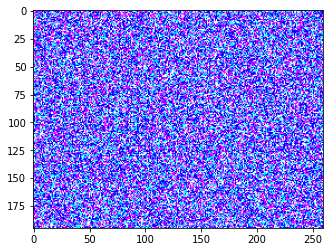

In [0]:
H = 195
W = 260
k = 40

# simulo una predizione della rete per un'immagine:
# genero un vettore di 40 elementi random (tra 0 e 1) per ogni pixel
netPrediction_mock = np.random.rand(H, W, k)
# individuo, per ogni pixel, l'indice del centroide "vincente", cioè per cui verrà impostata la prob. maggiore (es: 0.9)
# (serve per rendere più realistica la simulazione)
indici_predizione_max = np.random.randint(0, k, (H, W))
for i in range(H):
  for j in range(W):
    netPrediction_mock[i,j, indici_predizione_max[i,j]] = 0.9

# normalizzo in modo che la somma delle 40 probabilità per ogni pixel dia 1
somme = np.sum(netPrediction_mock, -1)
somme_rep = np.repeat(somme, k, axis = 1)
somme_resh = np.reshape(somme_rep, (H,W,k))
netPrediction_mock = netPrediction_mock / somme_resh

# chiamo la funzione di decodifica e ottengo la mappa delle normali 3d
netPrediction_3d = decode(netPrediction_mock, codebook, triangoli)
print(netPrediction_3d.shape)

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure('es. predizione decodificata')
plt.imshow(255/2 * netPrediction_3d) # ovviamente è roba random

Valutazione delle performance.

La metrica da utilizzare è la percentuale di pixel per cui la differenza angolare tra la normale predetta dalla rete e quella reale è inferiore ad una certa soglia.

In [0]:
# pixel wise evaluation
# INPUT
# prediction:   shape = (1,3) normale predetta dalla rete (ottenuta come codifica dalle label)
# ground_truth: shape = (1,3) normale effettiva
# OUTPUT
# l'errore in radianti tra la normale passata e quella effettiva
def eval_cosine(prediction, ground_truth):
  if np.sum(ground_truth) == 0 or np.sum(prediction) == 0:
    return 0
  cosine = np.dot(prediction, ground_truth) / (np.linalg.norm(prediction) * np.linalg.norm(ground_truth))
  if (cosine <= 1 and cosine >= -1):
    return np.arccos(cosine) 
  return np.deg2rad(180) if cosine < -1 else 0

# questa funzione va chiamata su tutti i pixel di tutte le immagini del test-set o validation set.

In [0]:

# TODO: effettuare la predizione su tutto il test-set (es: 30% del dataset "normals_orig.npy") con la rete. 
# Dopodichè decodificare le predizioni per ogni immagine (label -> normali 3d) e possibilmente salvare in un file (es: "prediction_test_decoded.npy").

# es. di test-set
idx_test = np.random.randint(0, N, int(0.3 * N))
normali_test = normali[idx_test]

# NOTA: nel calcolo della metrica non vanno considerati i pixel rumorosi, che sono identificati dalla tripla [0,0,0].
tot_noised_pixel = np.where(np.sum(normali_test, axis = -1) == 0)[0].shape[0]
tot_pixel = normali_test.shape[0] * normali_test.shape[1] * normali_test.shape[2]
valid_pixel = tot_pixel - tot_noised_pixel

print('Noised pixel / Tot pixel (%):', tot_noised_pixel / tot_pixel * 100)
print('Mean: ', np.rad2deg(np.sum(theta) / valid_pixel))

# es: carico da file
# theta = np.load("prediction_test_decoded.npy")

# valuto la percentuale di errori angolari inferiori rispetto ad una delle seguenti soglie
soglie_errori = [11.25, 22.5, 30]
for th in soglie_errori:
  under_th = (np.where(theta < np.deg2rad(th))[0].shape[0] - noised_pixel) / valid_pixel * 100
  print('Threshold', str(th),  under_th)


Noised pixel / Tot pixel (%): 10.237820626699646


NameError: ignored